# Data Assimilation examples used during Bingewatch Academy
## Bingewatch Academy
In my Bingewatch Academy talk I explored the question: "Why is Daredevil better at predicting events than normal humans?" I explained how data assimilation is used in weather forecasting to contiously combine observations and model predictions to get the best possible forecast of the future. In this notebook I will generate the figures that were used in my presentation. 

## Data assimilation
Data assimilation is the science of combining observational data and knowledge of system behavior to get an optimal estimation, including an estimation of the uncertainty in your estimation, of a systems past, current and/or future states. There are many different data asismilation variations: some focussing on a specific family of systems, some on specific use cases. In this example the data assimilation method that I use is the Ensemble Kalman Filter. The 'system', or 'model' that I use is the Lorenz-96 model.


## the Lorenz 96 model
The Lorenz 96 model <cite data-cite="2916206/TVEEWNWX"></cite> is a typical chaotic dynamical sytem that is often used as a benchmark model in data assimilation studies. It was desigende by Lorenz as a toy-model for aAtmospheric circulation. It is defined for $i=1,...,N$ by
\begin{equation}
\frac{dx_{i}}{dt}=\left(x_{i+1} - x_{i-2}\right)x_{i-1} - x_{i} + F
\end{equation}
where i is cyclical, ie. $x_{0}=x_{N}$ and $x_{-1} = x_{N-1}$. $F$ is an external force acting on the system. A value of $F=8$ is known to create chaotic bahavior and is often used. The dimension $N$ can be freely chosen and is typical $40$, but for testing very high dimension systems, higher values can be used. The Lorenz 96 model is a typical chaotic model where, although, the model is deterministic, slight variations in the input state will over time result in complete different states.

## Numerical implementation of the Lorenz 96 model
A fourth order Runga Kutta scheme is used to implement the Lorenz 96 model. Writing the entire state-vector as $\vec{x}$ and using $f\left(\vec{x}\right)$ as the right hand side of the model, ie:
\begin{eqnarray}
f\left(x_{i}\right) = \left(x_{i+1} - x_{i-2}\right)x_{i-1} - x_{i} + F
\\
f\left(\vec{x}\right) = \left\{f\left(x_{1}\right),...,f\left(x_{N}\right)\right\}
\end{eqnarray}
the implementation is given by:
\begin{eqnarray}
\vec{k}_{1}=f\left(\vec{x}\left(t\right)\right)
\\
\vec{k}_{2}=f\left(\vec{x}\left(t\right) + \frac{1}{2}\vec{k}_{1}\Delta t\right)
\\
\vec{k}_{3}=f\left(\vec{x}\left(t\right) + \frac{1}{2}\vec{k}_{2}\Delta t\right)
\\
\vec{k}_{4}=f\left(\vec{x}\left(t\right) + \vec{k}_{3}\Delta t\right)
\end{eqnarray}
and finally
\begin{equation}
\vec{x}\left(t + \Delta t\right) = \vec{x}\left(t\right) + \frac{1}{6}\left(\vec{k}_{1} + 2\vec{k}_{2} + 2 \vec{k}_{3} + \vec{k}_{4}\right)
\end{equation}

## The Basic Model Interface (BMI)
The basic model interface allows communicating with models in a generic fashion. It requires a few standard methods to be available such as 'initialize()' and 'update()'. Methods that are not relevant for the model need still be implemented, but can simply raise a one line exception. See <cite data-cite="2916206/VXTQPCA7"></cite> for more information. Implementing the BMI allows easy interaction with the model. The cells below initiate one instance of the model. For reasons that will become clear we will call this instance "truthModel".

BMI models are typically initialized with a settings-file. This is overkill here, but for completeness, we generate the settings-file first and than pass it to the model.

## Ensemble Kalman Filter example using Lorenz-96 model and BMI
The Ensemble Kalman Filter (EnKF) is a variant on the Kalman Filter used when dealing with models for which it is hard to define a tangiant model. Data Assimilation methods, including all variants of the Kalman Filter Family, set to provide the (mathimatically) optimal estimation of the true state of a system, given that a (often phyiscal/physially based) model is available that can project the current state of the model into the future and that at the same time observations are available that measure (parts of) the state, either directly or indirectly.

A mathematical overview of the EnKF is given in <cite data-cite="2916206/GVM9N4GZ"></cite>. This notebook is intended as an introduction on how to do data assimilation within the eWaterCycle framework, with models that communicate through BMI. It is not intended as an indepth explenation of the EnKF. 

## data assimilation jargon
The following terms are often used in data assimilation:

- **ensemble** is a collection of model-instances. Often these are multiple instances of the same model where the spread in the model state represents the uncertainty in our knowledge of that model state.
- **model** a mathematical and/or computer code represenation of how the state of the system evolves in time.  
- **observation** a measurement (or set of measurements, including images)that relate to (part of) the state of the system
- **observation model** a mathematical and/or computer code representation of how the state relates to the observations. Often donated by $\mathbf{H}$.
- **forecast** The forecasted state using the model and a previous state
- **analyses** The best estimate of the state using both a forecast and an observation. The analyses (or analyses-ensemble) is the output of a data assimilation method.



In [1]:
#required libraries and settings
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import io
import math

import BMILorenz
import EnKF

## settings
The settings for this experiment are split between settings for the model, for the observations and for the data assimilation method and finally for the experiment

In [2]:
##model

J = 40 #dimension of Lorenz-96 Model
commonStartState = np.zeros(J) #start-vector
commonStartState[5]=0.01

#settings data in dict for export to YAML file
settings = {'J': J,
            'F': 8.0,
            'startTime': 0.0,
            'endTime': 10.0,
            'dt':1e-3,
            'startState': commonStartState}



##Observations
observationSigma = [0.05,0.5]          #standard deviation of the observations. I'm running two different versions!
obsVector = range(math.floor(J/2))  #only observe half of the state
obsSize = len(obsVector);           #size of the observations vector
def H(state):                       #the "observation model" that links model-space to observation-space
    return state[obsVector]


##Ensemble Kalman Filter
N = 100                             #numeber of ensemble members, needs to be higher than dimension of the
                                    # model for stability, since no inflation is implemented.

## Experiment
spinUpTime = 3                      #time that the ensemble is run before data assimilation starts to 
updateInterval = 1                  #how often is the ensemble updated with observations

plotState = 5                       #which state of the model (both truth and ensemble) to plot
obsPlotState = 5                    #which state of the observations to plot

In [3]:
# Write YAML setting file for BMI model
with io.open('settings.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(settings, outfile, default_flow_style=False, allow_unicode=True)

In [4]:
#start with two empty ensembles. create one ensemble for the "high observational error" case and one for low errors.
ensembleLow = []
ensembleHigh = []


#create and initialize an instance of the BMILorenz class
truthModel = BMILorenz.BMILorenz ()
truthModel.initialize('settings.yaml')

output = pd.DataFrame(columns = ['truth','observation'])

for n in range (N):
    #add an ensemble methods
    ensembleLow.append(BMILorenz.BMILorenz ())
    ensembleLow[n].initialize('settings.yaml')
    ensembleLow[n].set_value_at_indices('state',5,ensembleLow[n].get_value_at_indices('state',5) + np.random.randn(1)*0.01)
    ensembleHigh.append(BMILorenz.BMILorenz ())
    ensembleHigh[n].initialize('settings.yaml')
    ensembleHigh[n].set_value_at_indices('state',5,ensembleHigh[n].get_value_at_indices('state',5) + np.random.randn(1)*0.01)
    
    #also add a column to the output dataframe to store the output
    output['ensembleLow' + str(n)]= np.nan
    output['ensembleHigh' + str(n)]= np.nan
    
 

In [5]:
#spin up the Ensemble. 

while truthModel.get_current_time()< spinUpTime:
    
    truthModel.update()
    output.loc[truthModel.get_current_time(),'truth'] = truthModel.get_value_at_indices('state',plotState)
    
    #observationLow = truthModel.get_value('state') + observationSigma[0] * np.random.randn(J)
    #output.at[truthModel.get_current_time(),'observationLow'] = observationLow[plotState]

    #observationHigh = truthModel.get_value('state') + observationSigma[1] * np.random.randn(J)
    #output.at[truthModel.get_current_time(),'observationJigh'] = observationHigh[plotState]
    
    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensembleLow[n].update()
        output.at[ensembleLow[n].get_current_time(),'ensembleLow' + str(n)] = ensembleLow[n].get_value_at_indices('state',plotState)
        ensembleHigh[n].update()
        output.at[ensembleHigh[n].get_current_time(),'ensembleHigh' + str(n)] = ensembleHigh[n].get_value_at_indices('state',plotState)
        
updateTime = spinUpTime


In [6]:
#run 

foreCastEnsembleLow = np.zeros([J,N])
foreCastEnsembleHigh = np.zeros([J,N])
observationEnsembleLow = np.zeros([obsSize,N])
observationEnsembleHigh = np.zeros([obsSize,N])

while truthModel.get_current_time()<truthModel.get_end_time():
    truthModel.update()
    output.loc[truthModel.get_current_time(),'truth'] = truthModel.get_value_at_indices('state',plotState)
    
    
    

    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensembleLow[n].update()
        ensembleHigh[n].update()
        #observationEnsemble[:,n] = observation + observationSigma*np.random.randn(obsSize)
        output.at[ensembleLow[n].get_current_time(),'ensembleLow' + str(n)] = ensembleLow[n].get_value_at_indices('state',plotState)
        output.at[ensembleHigh[n].get_current_time(),'ensembleHigh' + str(n)] = ensembleHigh[n].get_value_at_indices('state',plotState)
        
    #TODO update ensemble on bases of observation
    if truthModel.get_current_time() > updateTime:
        
        observationLow = H(truthModel.get_value('state')) + observationSigma[0] * np.random.randn(obsSize)
        output.at[truthModel.get_current_time(),'observationLow'] = observationLow[plotState]
        
        observationHigh = H(truthModel.get_value('state')) + observationSigma[1] * np.random.randn(obsSize)
        output.at[truthModel.get_current_time(),'observationHigh'] = observationHigh[plotState]

        for n in range (N):
            observationEnsembleHigh[:,n] = observationHigh + observationSigma[1]*np.random.randn(obsSize)
            observationEnsembleLow[:,n] = observationLow + observationSigma[0]*np.random.randn(obsSize)
            foreCastEnsembleLow[:,n] = ensembleLow[n].get_value('state')
            foreCastEnsembleHigh[:,n] = ensembleHigh[n].get_value('state')
        
        analysesEnsembleLow = EnKF.EnKF(foreCastEnsembleLow,observationEnsembleLow,H)
        np.clip(analysesEnsembleLow, -10, 20, out=analysesEnsembleLow)
        for n in range (N):
            ensembleLow[n].set_value('state',analysesEnsembleLow[:,n])

        analysesEnsembleHigh = EnKF.EnKF(foreCastEnsembleHigh,observationEnsembleHigh,H)
        np.clip(analysesEnsembleHigh, -10, 20, out=analysesEnsembleHigh)
        for n in range (N):
            ensembleHigh[n].set_value('state',analysesEnsembleHigh[:,n])
        

        
        updateTime = updateTime + updateInterval

    
 

## Here come the plots

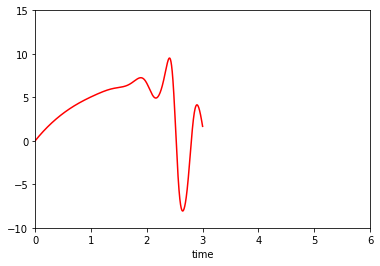

In [16]:
plt.plot(output.loc[output.index < 3,'truth'],'r')
plt.xlim([0,6])
plt.ylim([-10,15])
plt.xlabel('time')
plt.savefig('truth.eps')
plt.show()


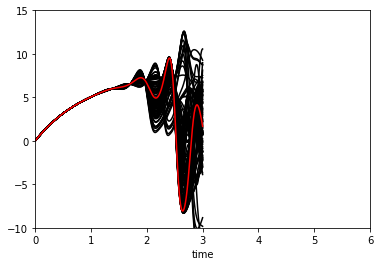

In [17]:
plt.plot(output.loc[output.index < 3,output.columns.str.startswith('ensembleHigh')],'k')
plt.plot(output.loc[output.index < 3,'truth'],'r')
plt.xlim([0,6])
plt.ylim([-10,15])
plt.xlabel('time')
plt.savefig('truthEnsemble.eps')
plt.show()

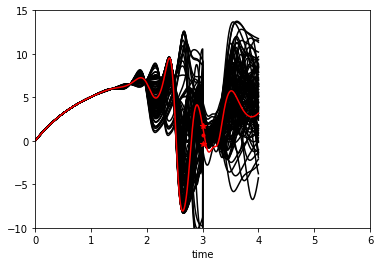

In [18]:
plt.plot(output.loc[output.index < 4,output.columns.str.startswith('ensembleHigh')],'k')
plt.plot(output.loc[output.index < 4,'observationHigh'],'r.',output.loc[output.index < 4,'observationHigh']+2*observationSigma[1],'r*',output.loc[output.index < 4,'observationHigh']-2*observationSigma[1],'r*')
plt.plot(output.loc[output.index < 4,'truth'],'r')
plt.xlim([0,6])
plt.ylim([-10,15])
plt.xlabel('time')
plt.savefig('EnKFHigh1step.eps')
plt.show()

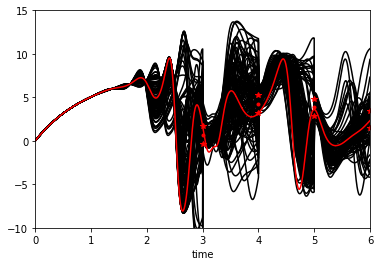

In [19]:
plt.plot(output.loc[output.index < 6,output.columns.str.startswith('ensembleHigh')],'k')
plt.plot(output.loc[output.index < 6,'observationHigh'],'r.',output.loc[:,'observationHigh']+2*observationSigma[1],'r*',output.loc[:,'observationHigh']-2*observationSigma[1],'r*')
plt.plot(output.loc[output.index < 6,'truth'],'r')
plt.xlim([0,6])
plt.ylim([-10,15])
plt.xlabel('time')
plt.savefig('EnKFHigh.eps')
plt.show()

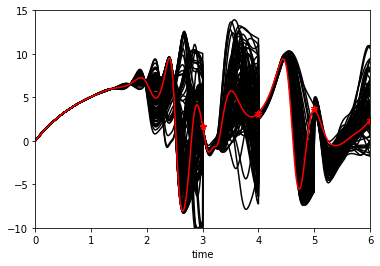

In [20]:
plt.plot(output.loc[output.index < 6,output.columns.str.startswith('ensembleLow')],'k')
plt.plot(output.loc[output.index < 6,'observationLow'],'r.',output.loc[:,'observationLow']+2*observationSigma[0],'r*',output.loc[:,'observationLow']-2*observationSigma[0],'r*')
plt.plot(output.loc[output.index < 6,'truth'],'r')
plt.xlim([0,6])
plt.ylim([-10,15])
plt.xlabel('time')
plt.savefig('EnKFLow.eps')
plt.show()

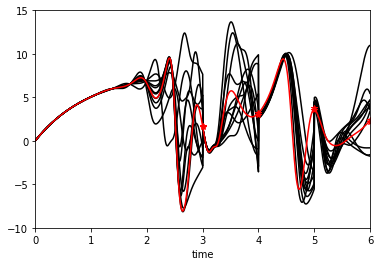

In [23]:
plt.plot(output.loc[output.index < 6,output.columns.str.startswith('ensembleLow1')],'k')
plt.plot(output.loc[output.index < 6,'observationLow'],'r.',output.loc[:,'observationLow']+2*observationSigma[0],'r*',output.loc[:,'observationLow']-2*observationSigma[0],'r*')
plt.plot(output.loc[output.index < 6,'truth'],'r')
plt.xlim([0,6])
plt.ylim([-10,15])
plt.xlabel('time')
plt.savefig('EnKFLow10ens.eps')
plt.show()

<div class="cite2c-biblio"></div>